# KNN classifier for predicting day of week

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

## load modified data from csv

see nick-explanatory.ipynb for csv creation

In [2]:
features = pd.read_csv('nick_df_features.csv',index_col=0)

In [3]:
features.sample(5)

,Date,Weekday,BlockDensity,OtherPuzAns,AnswerLength,WeekdayNum
8041,2016-04-17,Sunday,16.326531,7510,5.271429,6
4689,2007-02-03,Saturday,13.777778,1162,5.388889,5
3780,2004-06-14,Monday,16.000000,5977,5.108108,0
1888,1999-03-28,Sunday,16.780045,8156,5.267606,6
3342,2003-03-27,Thursday,16.000000,4658,4.846154,3


Feature description:
- **BlockDensity**: percentage of the puzzle that is black blocks
- **OtherPuzAns**: the number of other puzzles that contain clues from this puzzle
- **AnswerLength**: the average answer length for the puzzle
- **WeekdayNum**: weekday as number (Monday = 0), in case the model needs digits?

In [4]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

## plot our features

Maybe I'll try the fancy rotating plot later

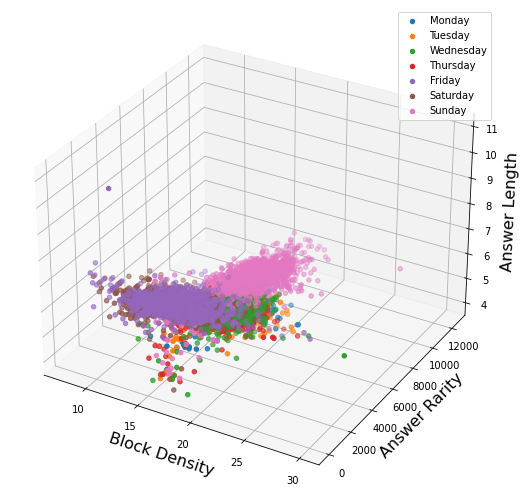

In [5]:
fig, ax = plt.subplots(figsize = (12,9))

ax = plt.axes(projection ="3d")
for i in range(7):
    ax.scatter3D(features['BlockDensity'].loc[features['WeekdayNum'] == i],
                  features['OtherPuzAns'].loc[features['WeekdayNum'] == i],
                  features['AnswerLength'].loc[features['WeekdayNum'] == i],
                  label=features['Weekday'].loc[features['WeekdayNum'] == i].iloc[0])

ax.set_xlabel("Block Density", fontsize = 16)
ax.set_ylabel("Answer Rarity", fontsize = 16)
ax.set_zlabel("Answer Length", fontsize = 16)
plt.legend()
plt.show()

## convert features to numpy arrays

In [6]:
X = features[['BlockDensity','OtherPuzAns','AnswerLength']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

## get accuracy on training set

Matt did it 🤷‍♀️

In [8]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [9]:
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(n_neighbors=3)

In [10]:
y_predict = knn.predict(X_train)

In [11]:
print("Our model has a",
      np.round(sum(y_predict == y_train.ravel())/len(y_train.ravel())*100,2),
      "% accuracy on the training set")

Our model has a 61.23 % accuracy on the training set


## cross validation

In [12]:
kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

In [13]:
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)

In [14]:
max_neighbors = 200

accs = np.zeros((5,max_neighbors))

j = 0

for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train, X_train_test = X_train[train_index], X_train[test_index]
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    for i in range(1, max_neighbors+1):
        knn = KNeighborsClassifier(i)
        knn.fit(X_train_train, y_train_train.ravel())
        accs[j, i-1] = get_acc(knn,X_train_test,y_train_test.ravel())
    j+=1

## plot CV accuracy

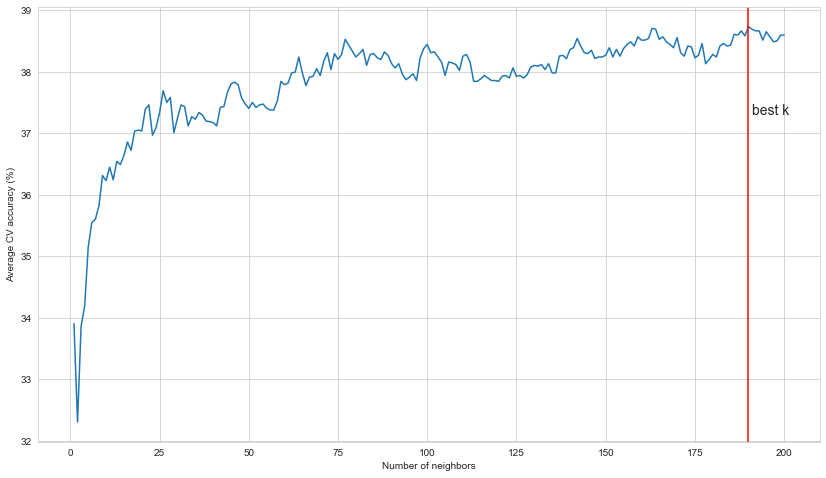

In [22]:
best_k = np.argmax(np.mean(accs, axis=0))+1
#sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14,8))

ax.plot(range(1,max_neighbors+1),100*np.mean(accs,axis=0))
ax.axvline(x=best_k, color='r')
ax.annotate("best k",(best_k+1,37.3), fontsize=14)
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Average CV accuracy (%)")

plt.show()

In [16]:
print(f"The highest accuraccy is in the model with {best_k} neighbors.")

The highest accuraccy is in the model with 190 neighbors.


In [17]:
knn = KNeighborsClassifier(n_neighbors = best_k)

knn.fit(X_train,y_train.ravel())
best_k_acc = np.round(get_acc(knn,X_test,y_test.ravel())*100,2)

print(f"The model with {best_k} neighbors has a {best_k_acc}% accuracy on the test set.")

The model with 190 neighbors has a 39.3% accuracy on the test set.


It's still not very good. 😢

But it's better than 14%, which is guessing days at chance?

## investigating results by day

In [18]:
day_accs = []
for i in range(7):
    day_name = class_labels[i]
    mask = y_test == i
    X = X_test[np.where(mask)[0]] # this will feed the indices where y_test is i
    y = y_test[np.where(mask)[0]]
    acc = get_acc(knn,X,y.ravel())
    day_accs.append((i, acc, day_name))
    print(f"{day_name} accuracy: \t{np.round(acc*100,2)}%")

Monday accuracy: 	43.14%
Tuesday accuracy: 	11.43%
Wednesday accuracy: 	21.14%
Thursday accuracy: 	40.17%
Friday accuracy: 	31.91%
Saturday accuracy: 	50.58%
Sunday accuracy: 	77.08%


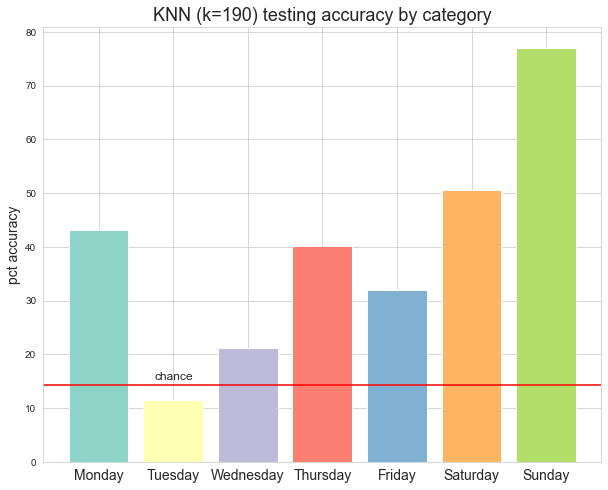

In [24]:
cmap = cm.get_cmap('Set3')
plt.figure(figsize=(10,8))
for i, acc, day in day_accs:
    plt.bar(i, acc*100, label=day, color=cmap.colors[i])
plt.axhline(y=(100/7), color='r', linestyle='-')
plt.annotate("chance",(0.75,(100/7)+1),fontsize=12)
plt.xticks([i for i, acc, day in day_accs],[day for i, acc, day in day_accs], fontsize=14)
plt.ylabel("pct accuracy", fontsize=14)
plt.title(f"KNN (k={best_k}) testing accuracy by category", fontsize=18)

plt.show()

In [20]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[151,  26,  72,  51,   6,   7,  37],
       [122,  40,  59,  88,  12,  10,  19],
       [ 89,  45,  74,  97,  19,  12,  14],
       [ 46,  14,  74, 139,  37,  32,   4],
       [ 11,   2,  14,  77, 112, 135,   0],
       [  2,   0,   5,  37, 126, 174,   0],
       [ 58,   6,   3,   1,   3,   9, 269]], dtype=int64)

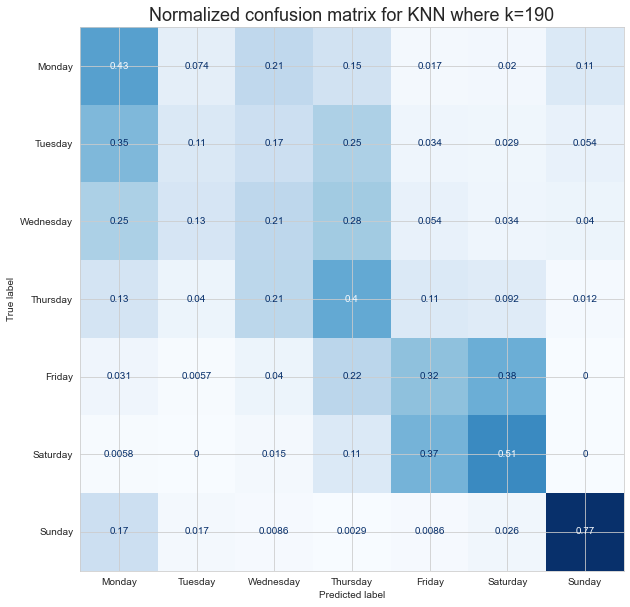

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(knn, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"Normalized confusion matrix for KNN where k={best_k}", fontsize=18)
plt.show()